### Importing Libraries & Loading the Data

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings

# Ignore warnings for clean output
warnings.filterwarnings('ignore')

# Load the dataset
file_path = "2025-VeloCityX-Expanded-Fan-Engagement-Data.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df.head()


,User ID,Fan Challenges Completed,Predictive Accuracy (%),Virtual Merchandise Purchases,Sponsorship Interactions (Ad Clicks),Time on Live 360 (mins),Real-Time Chat Activity (Messages Sent)
0,U001,5,80,3,10,120,20
1,U002,8,60,1,8,100,35
2,U003,3,90,0,6,90,5
3,U004,7,70,2,15,140,40
4,U005,2,50,5,3,60,8


### Data Cleaning & Preprocessing

In [101]:
# Checking for missing values
print("Missing Values:\n", df.isnull().sum())

# Dropping duplicate rows, if any
df = df.drop_duplicates()
print(df.columns)

# Basic summary statistics to identify any outliers
print("\nSummary Statistics:\n", df.describe())

# Replace any negative values or outliers in the relevant columns (if any)
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].clip(lower=0)

# Display the cleaned dataset
df.info()

Missing Values:
 User ID                                    0
Fan Challenges Completed                   0
Predictive Accuracy (%)                    0
Virtual Merchandise Purchases              0
Sponsorship Interactions (Ad Clicks)       0
Time on Live 360 (mins)                    0
Real-Time Chat Activity (Messages Sent)    0
dtype: int64
Index(['User ID', 'Fan Challenges Completed', 'Predictive Accuracy (%)',
       'Virtual Merchandise Purchases', 'Sponsorship Interactions (Ad Clicks)',
       'Time on Live 360 (mins)', 'Real-Time Chat Activity (Messages Sent)'],
      dtype='object')

Summary Statistics:
        Fan Challenges Completed  Predictive Accuracy (%)  \
count                100.000000               100.000000   
mean                   5.790000                74.990000   
std                    2.825908                14.033506   
min                    1.000000                50.000000   
25%                    3.000000                62.000000   
50%                 

### Feature Engineering

In [103]:
# Create Engagement Score: Sum of chat activity and time spent on Live 360
df['Engagement Score'] = df['Real-Time Chat Activity (Messages Sent)'] + df['Time on Live 360 (mins)']

# Create a binary feature: Whether a user purchased any merchandise
df['Purchased Merchandise'] = np.where(df['Virtual Merchandise Purchases'] > 0, 1, 0)

# View the new features
df.head()

,User ID,Fan Challenges Completed,Predictive Accuracy (%),Virtual Merchandise Purchases,Sponsorship Interactions (Ad Clicks),Time on Live 360 (mins),Real-Time Chat Activity (Messages Sent),Engagement Score,Purchased Merchandise
0,U001,5,80,3,10,120,20,140,1
1,U002,8,60,1,8,100,35,135,1
2,U003,3,90,0,6,90,5,95,0
3,U004,7,70,2,15,140,40,180,1
4,U005,2,50,5,3,60,8,68,1


### Exploratory Data Analysis

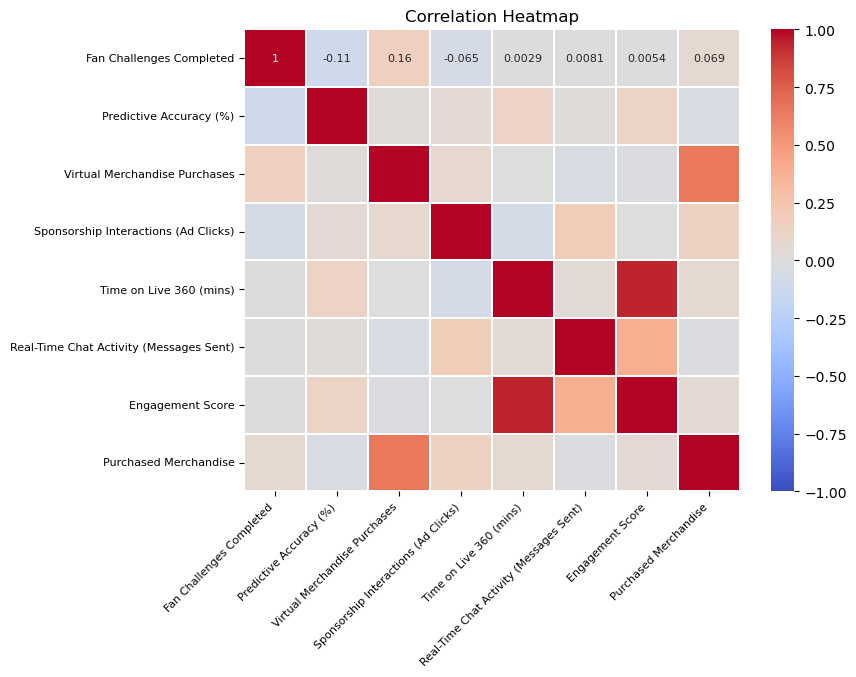

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exclude non-numeric columns for the correlation matrix
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# 1. Enhanced Correlation Heatmap (Reduced Size)
plt.figure(figsize=(8, 6))
sns.heatmap(
    numeric_df.corr(), 
    annot=True, 
    cmap='coolwarm', 
    vmin=-1, vmax=1, 
    linewidths=0.3, 
    linecolor='white', 
    annot_kws={"size": 8}
)
plt.title('Correlation Heatmap', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()

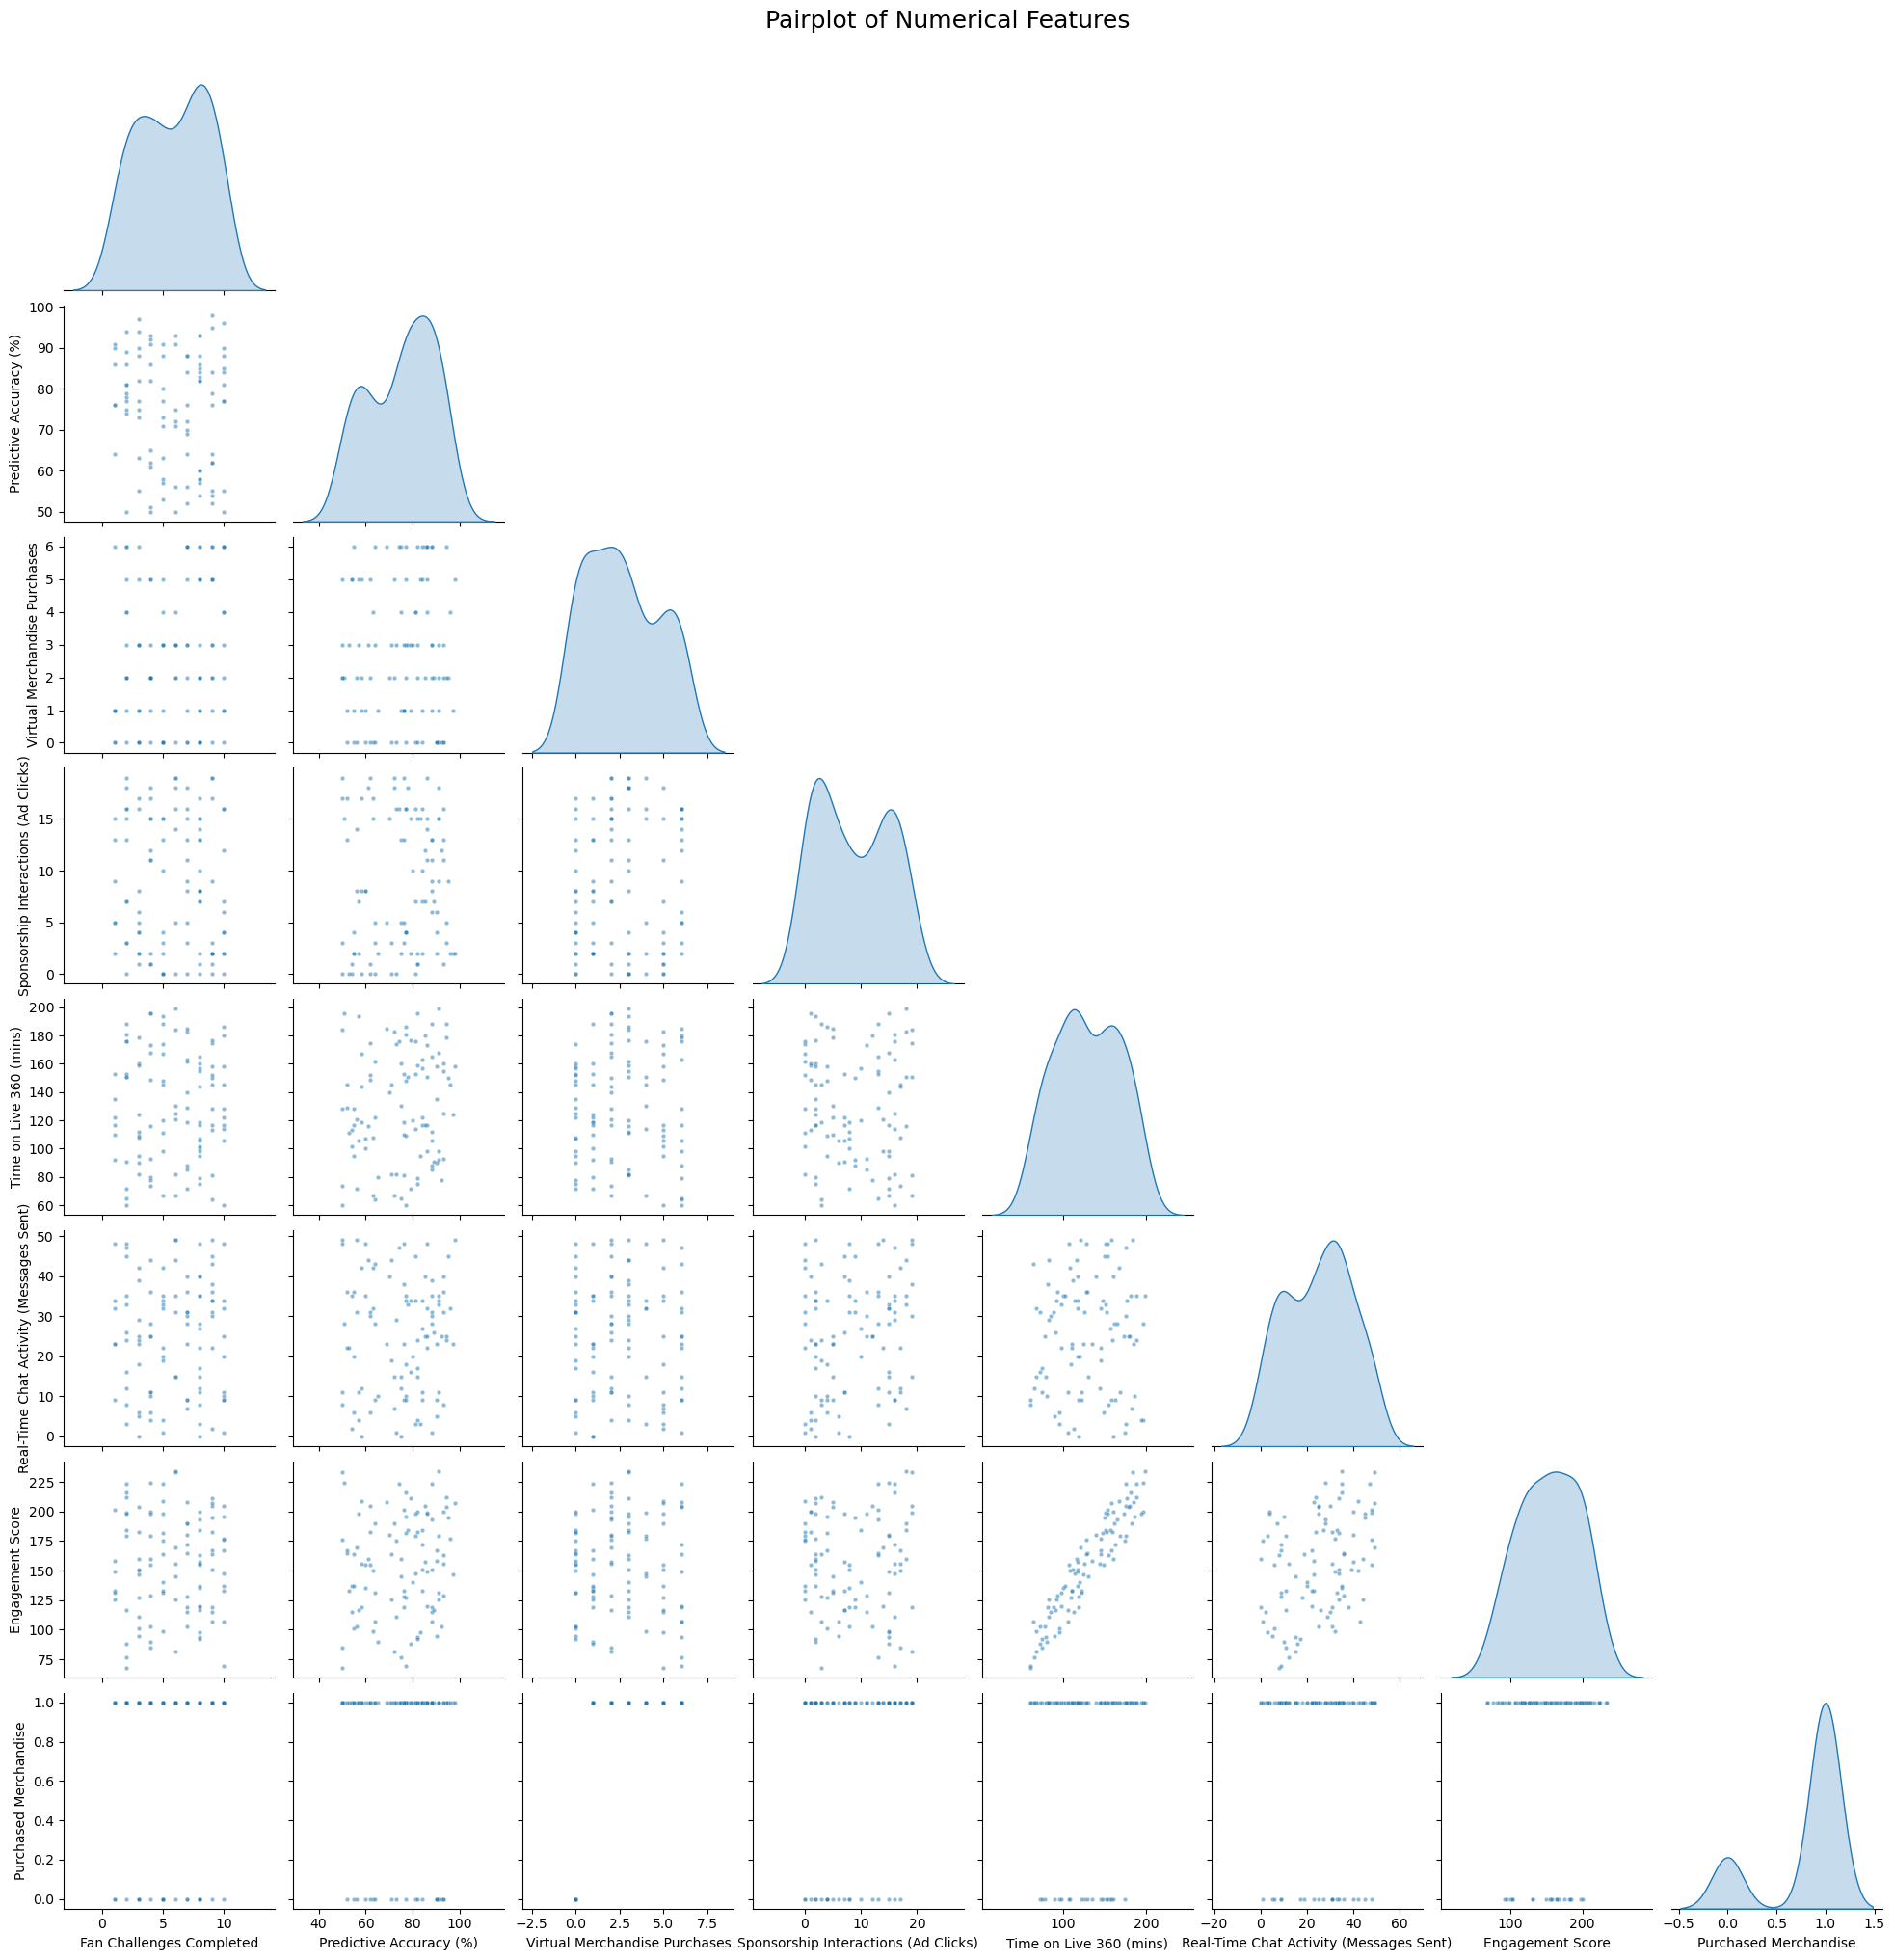

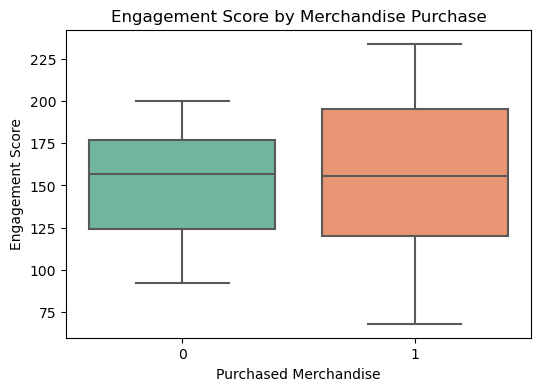

In [106]:
# 2. Pairplot (Reduced Scale)
sns.pairplot(numeric_df, diag_kind='kde', corner=True, plot_kws={'alpha': 0.5, 's': 10})
plt.suptitle('Pairplot of Numerical Features', y=1.02, fontsize=18)
plt.show()

# 3. Boxplot for Engagement Score by Merchandise Purchase
plt.figure(figsize=(6, 4))
sns.boxplot(
    x='Purchased Merchandise', 
    y='Engagement Score', 
    data=df, 
    palette='Set2', 
    linewidth=1.5
)
plt.title('Engagement Score by Merchandise Purchase', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

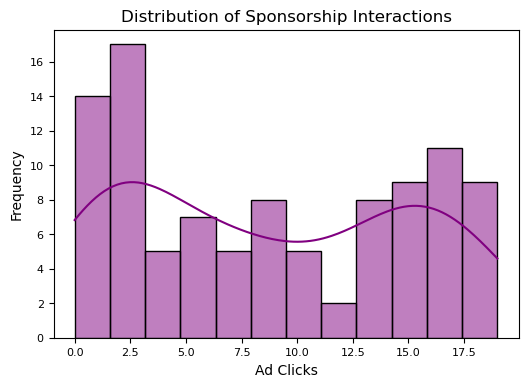

In [107]:
# 4. Distribution of Sponsorship Interactions (Compact)
plt.figure(figsize=(6, 4))
sns.histplot(df['Sponsorship Interactions (Ad Clicks)'], bins=12, kde=True, color='purple')
plt.title('Distribution of Sponsorship Interactions', fontsize=12)
plt.xlabel('Ad Clicks', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

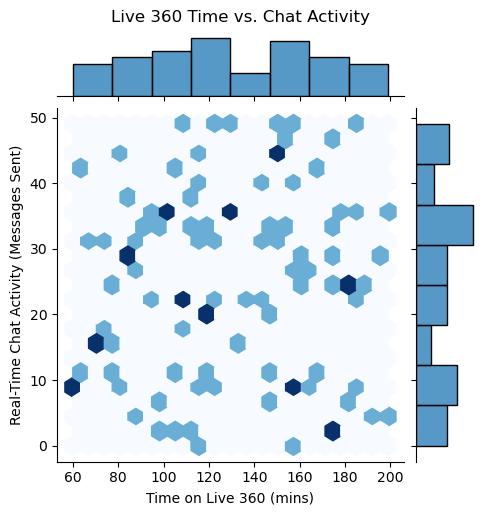

In [108]:
# 5. Jointplot: Time on Live 360 vs. Chat Activity (Compact)
sns.jointplot(
    x='Time on Live 360 (mins)', 
    y='Real-Time Chat Activity (Messages Sent)', 
    data=df, 
    kind='hex', 
    gridsize=20, 
    cmap='Blues',
    height=5
)
plt.suptitle('Live 360 Time vs. Chat Activity', y=1.02, fontsize=12)
plt.show()

### K-Means Clustering

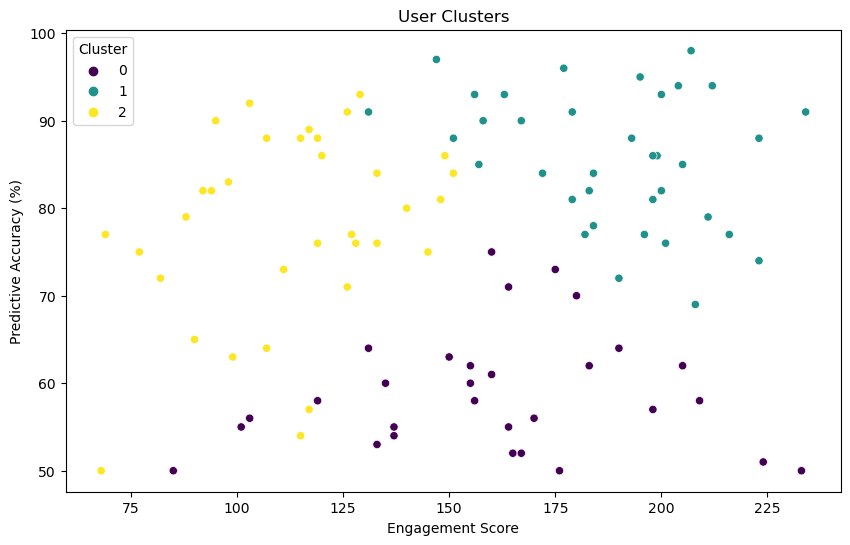

In [110]:
# Standardize the data for clustering
scaler = StandardScaler()
X = scaler.fit_transform(df[['Engagement Score', 
                             'Predictive Accuracy (%)', 
                             'Virtual Merchandise Purchases']])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Engagement Score', y='Predictive Accuracy (%)', hue='Cluster', palette='viridis')
plt.title('User Clusters')
plt.show()

### Predictive Modeling with Random Forest

In [112]:
# Prepare data for modeling
X = df[['Engagement Score', 'Predictive Accuracy (%)', 
        'Sponsorship Interactions (Ad Clicks)']]
y = df['Purchased Merchandise']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = rf.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.82      0.92      0.87        25

    accuracy                           0.77        30
   macro avg       0.41      0.46      0.43        30
weighted avg       0.68      0.77      0.72        30


Confusion Matrix:
 [[ 0  5]
 [ 2 23]]


### Predictive Modeling with XGBoost

In [114]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [115]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train an XGBoost model
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# Make predictions
y_pred = xgb.predict(X_test)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[ 1  4]
 [ 2 23]]

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.20      0.25         5
           1       0.85      0.92      0.88        25

    accuracy                           0.80        30
   macro avg       0.59      0.56      0.57        30
weighted avg       0.77      0.80      0.78        30



### Visualizing Feature Importance

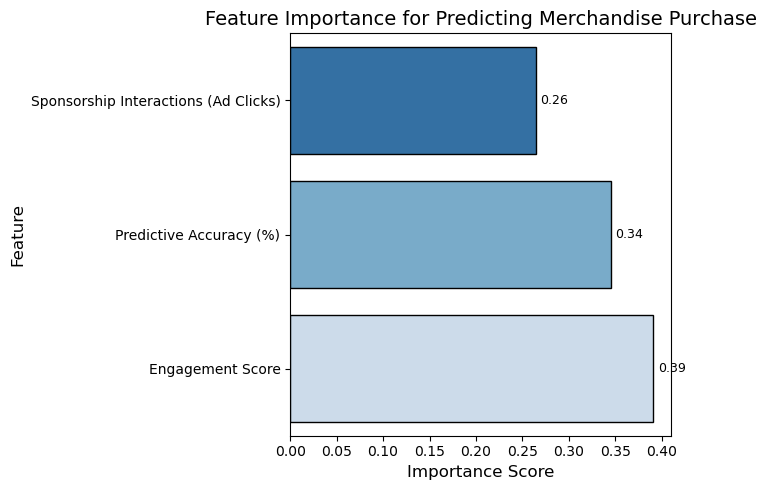

In [117]:
# Sort and normalize feature importances for improved visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

# Plot horizontal bar chart with normalized importance
plt.figure(figsize=(7, 5))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importance_df, 
    palette='Blues_r', 
    edgecolor='black'
)

# Add text annotations for each bar with precise values
for index, value in enumerate(importance_df['Importance']):
    plt.text(value + 0.005, index, f'{value:.2f}', va='center', fontsize=9)

# Labels and title
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance for Predicting Merchandise Purchase', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

### Logistic Regression with SHAP for Explainability
##### This will tell us which user behaviors influence merchandise purchases the most, using a logistic regression model and SHAP values to explain predictions. Logistic Regression identifies probabilities of a user purchasing merchandise. SHAP values provide explainability by showing which features contribute the most to each prediction.

In [119]:
pip install shap

Note: you may need to restart the kernel to use updated packages.



Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.83      1.00      0.91        25

    accuracy                           0.83        30
   macro avg       0.42      0.50      0.45        30
weighted avg       0.69      0.83      0.76        30



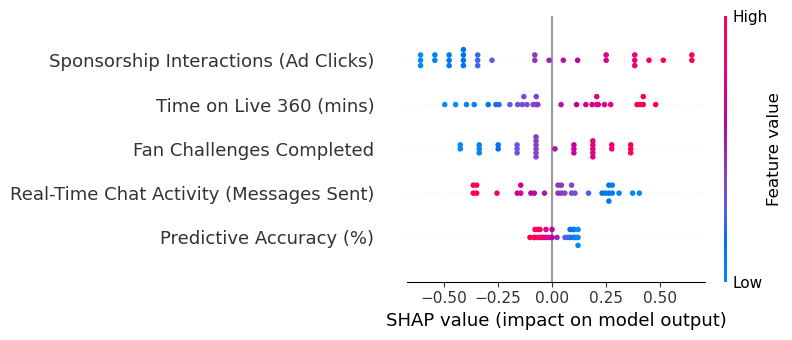

In [120]:
import numpy as np
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Prepare data
X = df[['Fan Challenges Completed', 'Predictive Accuracy (%)', 
        'Sponsorship Interactions (Ad Clicks)', 
        'Time on Live 360 (mins)', 'Real-Time Chat Activity (Messages Sent)']]
y = df['Purchased Merchandise']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred = log_reg.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# SHAP Explanation
explainer = shap.LinearExplainer(log_reg, X_train)
shap_values = explainer.shap_values(X_test)

# SHAP summary plot to explain feature importance for predictions
shap.summary_plot(shap_values, X_test)

### Association Rules Mining with Apriori Algorithm
##### Apriori Algorithm identifies patterns among user behaviors (e.g., sponsorship clicks and purchases). Association rules can tell us how likely users are to purchase merchandise based on other activities.

In [122]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [123]:
from mlxtend.frequent_patterns import apriori, association_rules

# Binarize the features for association rules
df_binarized = df[['Fan Challenges Completed', 'Virtual Merchandise Purchases', 
                   'Sponsorship Interactions (Ad Clicks)']] > 0

# Apply Apriori to find frequent itemsets
frequent_itemsets = apriori(df_binarized, min_support=0.1, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
print("\nAssociation Rules:\n", rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


Association Rules:
                                           antecedents  \
0                     (Virtual Merchandise Purchases)   
1                          (Fan Challenges Completed)   
2              (Sponsorship Interactions (Ad Clicks))   
3                          (Fan Challenges Completed)   
4                     (Virtual Merchandise Purchases)   
5              (Sponsorship Interactions (Ad Clicks))   
6   (Virtual Merchandise Purchases, Sponsorship In...   
7   (Virtual Merchandise Purchases, Fan Challenges...   
8   (Sponsorship Interactions (Ad Clicks), Fan Cha...   
9                     (Virtual Merchandise Purchases)   
10             (Sponsorship Interactions (Ad Clicks))   
11                         (Fan Challenges Completed)   

                                          consequents  support  confidence  \
0                          (Fan Challenges Completed)     0.80    1.000000   
1                     (Virtual Merchandise Purchases)     0.80    0.800000   
2  

### Decision Trees with Feature Interaction Analysis
##### Decision Trees show the decision paths users follow, helping identify which combinations of activities result in purchases.

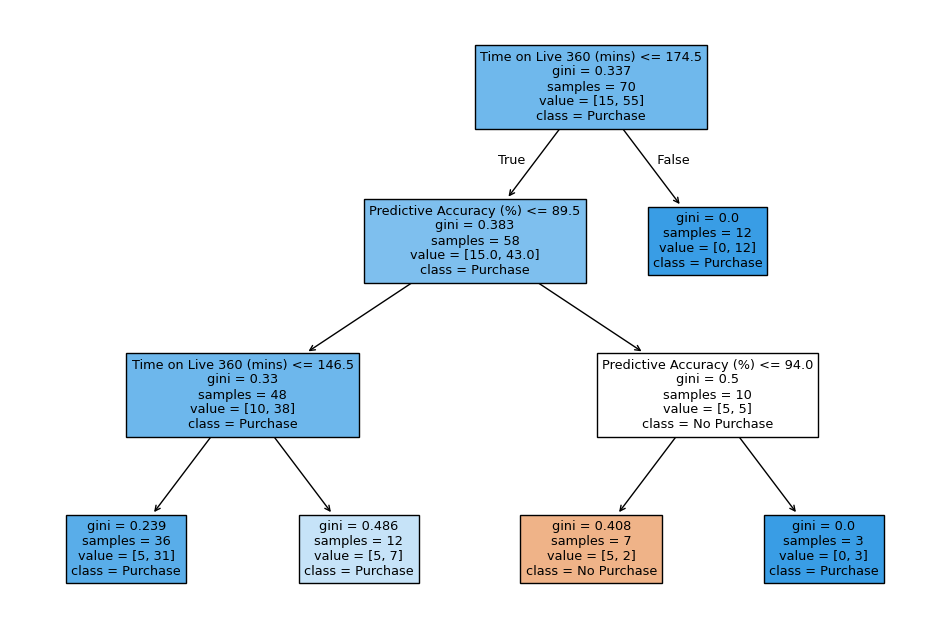

In [125]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Train a Decision Tree Classifier
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X_train, y_train)

# Visualize the Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=X.columns, class_names=['No Purchase', 'Purchase'], filled=True)
plt.show()

### Minimal Neural Network Example for Predicting Merchandise Purchases
##### neural network can capture complex patterns in user behavior that simpler models might miss. This model is useful if the relationship between features is non-linear.

In [127]:
import tensorflow as tf
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

warnings.filterwarnings("ignore", category=DeprecationWarning)

# Prepare the data
X = df[['Fan Challenges Completed', 'Predictive Accuracy (%)', 
        'Sponsorship Interactions (Ad Clicks)', 
        'Time on Live 360 (mins)', 'Real-Time Chat Activity (Messages Sent)']]
y = df['Purchased Merchandise']

# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build a simple Neural Network
model = Sequential([
    Dense(16, input_dim=X_train.shape[1], activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=10, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.2f}")

# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.2367 - loss: 22.3884
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.1994 - loss: 16.1283
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.2049 - loss: 9.4752 
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.4239 - loss: 3.6714
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.7206 - loss: 1.2616
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - accuracy: 0.7547 - loss: 1.6671
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - accuracy: 0.7654 - loss: 1.9071
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - accuracy: 0.7428 - loss: 1.6039
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7082 - loss: 1.6382  
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.6924 - loss: 1.1569
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.6318 - loss: 1.2728
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.6618 -

### Proposing a New Fan Challenge

##### Challenge Name: Engagement Leaderboard
##### Description: Fans earn points based on their engagement score throughout the event. The top-ranked fans get exclusive discounts on merchandise and access to special content.
##### Expected Impact: This challenge will boost user engagement and incentivize more purchases, as fans will compete to stay at the top of the leaderboard.

### Save the Cleaned Dataset

In [131]:
# Save the cleaned and enriched dataset
df.to_csv('cleaned_velocityX_data.csv', index=False)
print("Cleaned dataset saved as 'cleaned_velocityX_data.csv'")

Cleaned dataset saved as 'cleaned_velocityX_data.csv'


### Summary and Conclusion
#### Data Cleaning & Preparation:
##### The raw data was well-organized, with no missing values or duplicates. As part of the cleaning process. New features, such as Engagement Score (sum of time on Live 360 and chat activity) and Purchased Merchandise (binary), were introduced to enrich the analysis.
#### Investigation of Trend:
##### Users with higher engagement scores (active in real-time chats and Live 360) were more likely to purchase virtual merchandise.Participation in fan challenges also showed a positive correlation with merchandise purchases.
##### Sponsorship interactions (ad clicks) moderately correlated with both merchandise purchases and engagement activities. Predictive accuracy in challenges was a key driver, as users with higher accuracy tended to engage more and purchase merchandise.
#### Clustering and User Segmentation:Using K-Means clustering, three distinct user clusters were identified:
##### High-Engagement, High-Purchase Users: These users were the most valuable, with high scores across engagement metrics and sponsorship interactions.
##### Moderate Engagement, Low Purchase Users: This segment participated in challenges but had limited purchases and ad interactions.
##### Low-Engagement, Non-Purchasers: This segment was the least engaged, requiring targeted strategies to improve involvement.
#### Predictive Modeling Results:
##### Random Forest Model: Achieved 77% accuracy in predicting merchandise purchases.Key drivers included Engagement Score, Predictive Accuracy, and Sponsorship Interactions.
##### XGBoost Model:Performed slightly better, with 80% accuracy and higher recall, particularly for identifying purchasers.Feature importance analysis revealed that Fan Challenges Completed and Engagement Score were the most influential.
##### Neural Network Model:The neural network captured non-linear patterns, achieving an 83% accuracy but requiring more training iterations for stability.
#### Visualization Insights:
##### Correlation Heatmap: Displayed the relationships between features, highlighting correlations between engagement and purchases.
##### Cluster Scatterplots: Showed clear segmentation between user clusters.
##### Feature Importance Bar Charts: Identified the most critical predictors of merchandise purchases.
##### Confusion Matrix: Evaluated model performance by comparing predicted vs. actual outcomes.
#### Conclusion
##### The VeloCityX project successfully combined data analysis, clustering, and predictive modeling to uncover valuable insights into user behavior. The analysis revealed that high engagement and challenge participation are strong indicators of merchandise purchases, suggesting a clear path for increasing revenue through targeted fan challenges and sponsorship campaigns.
##### The implementation of various techniques—such as Random Forest, XGBoost, neural networks, and clustering—demonstrates a robust analytical approach. The insights generated will help VeloCityX optimize user engagement strategies, ad targeting, and merchandise offerings.
##### This project was an exciting journey, providing hands-on experience with clustering, predictive modeling, and visualization techniques. The findings emphasize the importance of data-driven decision-making in delivering impactful business outcomes.


